In [260]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import sys
import shapely
import Helper_Methods as hm
from scipy.spatial import cKDTree
import numpy as np

In [133]:
%%time
route_paths = "./Data/Routes/Comprehensive_Routes/KCM_Routes.shp"
routes = gpd.read_file(route_paths)

CPU times: user 600 ms, sys: 7.73 ms, total: 607 ms
Wall time: 606 ms


In [285]:
%%time
elevations_path = "./Data/Lidar/LIDAR.shp"
elevations_raw = gpd.read_file(elevations_path)
elevations = elevations_raw.copy()

CPU times: user 1min 18s, sys: 972 ms, total: 1min 19s
Wall time: 1min 18s


In [288]:
elevations.crs

<Projected CRS: EPSG:2926>
Name: NAD83(HARN) / Washington North (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Washington - counties of Chelan; Clallam; Douglas; Ferry; Grant north of approximately 47°30'N; Island; Jefferson; King; Kitsap; Lincoln; Okanogan; Pend Oreille; San Juan; Skagit; Snohomish; Spokane; Stevens; Whatcom.
- bounds: (-124.79, 47.08, -117.02, 49.05)
Coordinate Operation:
- name: SPCS83 Washington North zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [289]:
elevations = elevations.to_crs(epsg = 4326)

In [291]:
route = 45

In [292]:
def organize_linestring(string):
    cat_string = string[12:-1]
    coord_list = cat_string.split(', ')
    coord_ser = pd.Series(coord_list).apply(lambda x: shapely.Point(x.split(' ')[0], x.split(' ')[1]))
    coord_ser = gpd.GeoSeries(coord_ser)
    return coord_ser

In [293]:
def pair_elevations(gdA, gdB):
    # https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest['Height'],
            pd.Series(dist, name='dist')
        ], 
        axis=1)
    gdf = gdf.rename(columns={"Height":"elevation"})

    return gdf
    
    

In [294]:
pair_elevations(geometry, elevations)

,0,elevation,dist
0,POINT (-122.28511 47.66270),5189.41,0.000324
1,POINT (-122.28538 47.66244),5188.77,0.000595
2,POINT (-122.28561 47.66223),5188.77,0.000773
3,POINT (-122.28582 47.66204),5188.77,0.001002
4,POINT (-122.28613 47.66184),5188.04,0.001331
...,...,...,...
585,POINT (-122.39698 47.69057),5119.79,0.002085
586,POINT (-122.39686 47.69057),5119.79,0.001966
587,POINT (-122.39686 47.69057),5119.79,0.001966
588,POINT (-122.39653 47.69057),5119.79,0.001643


<Axes: >

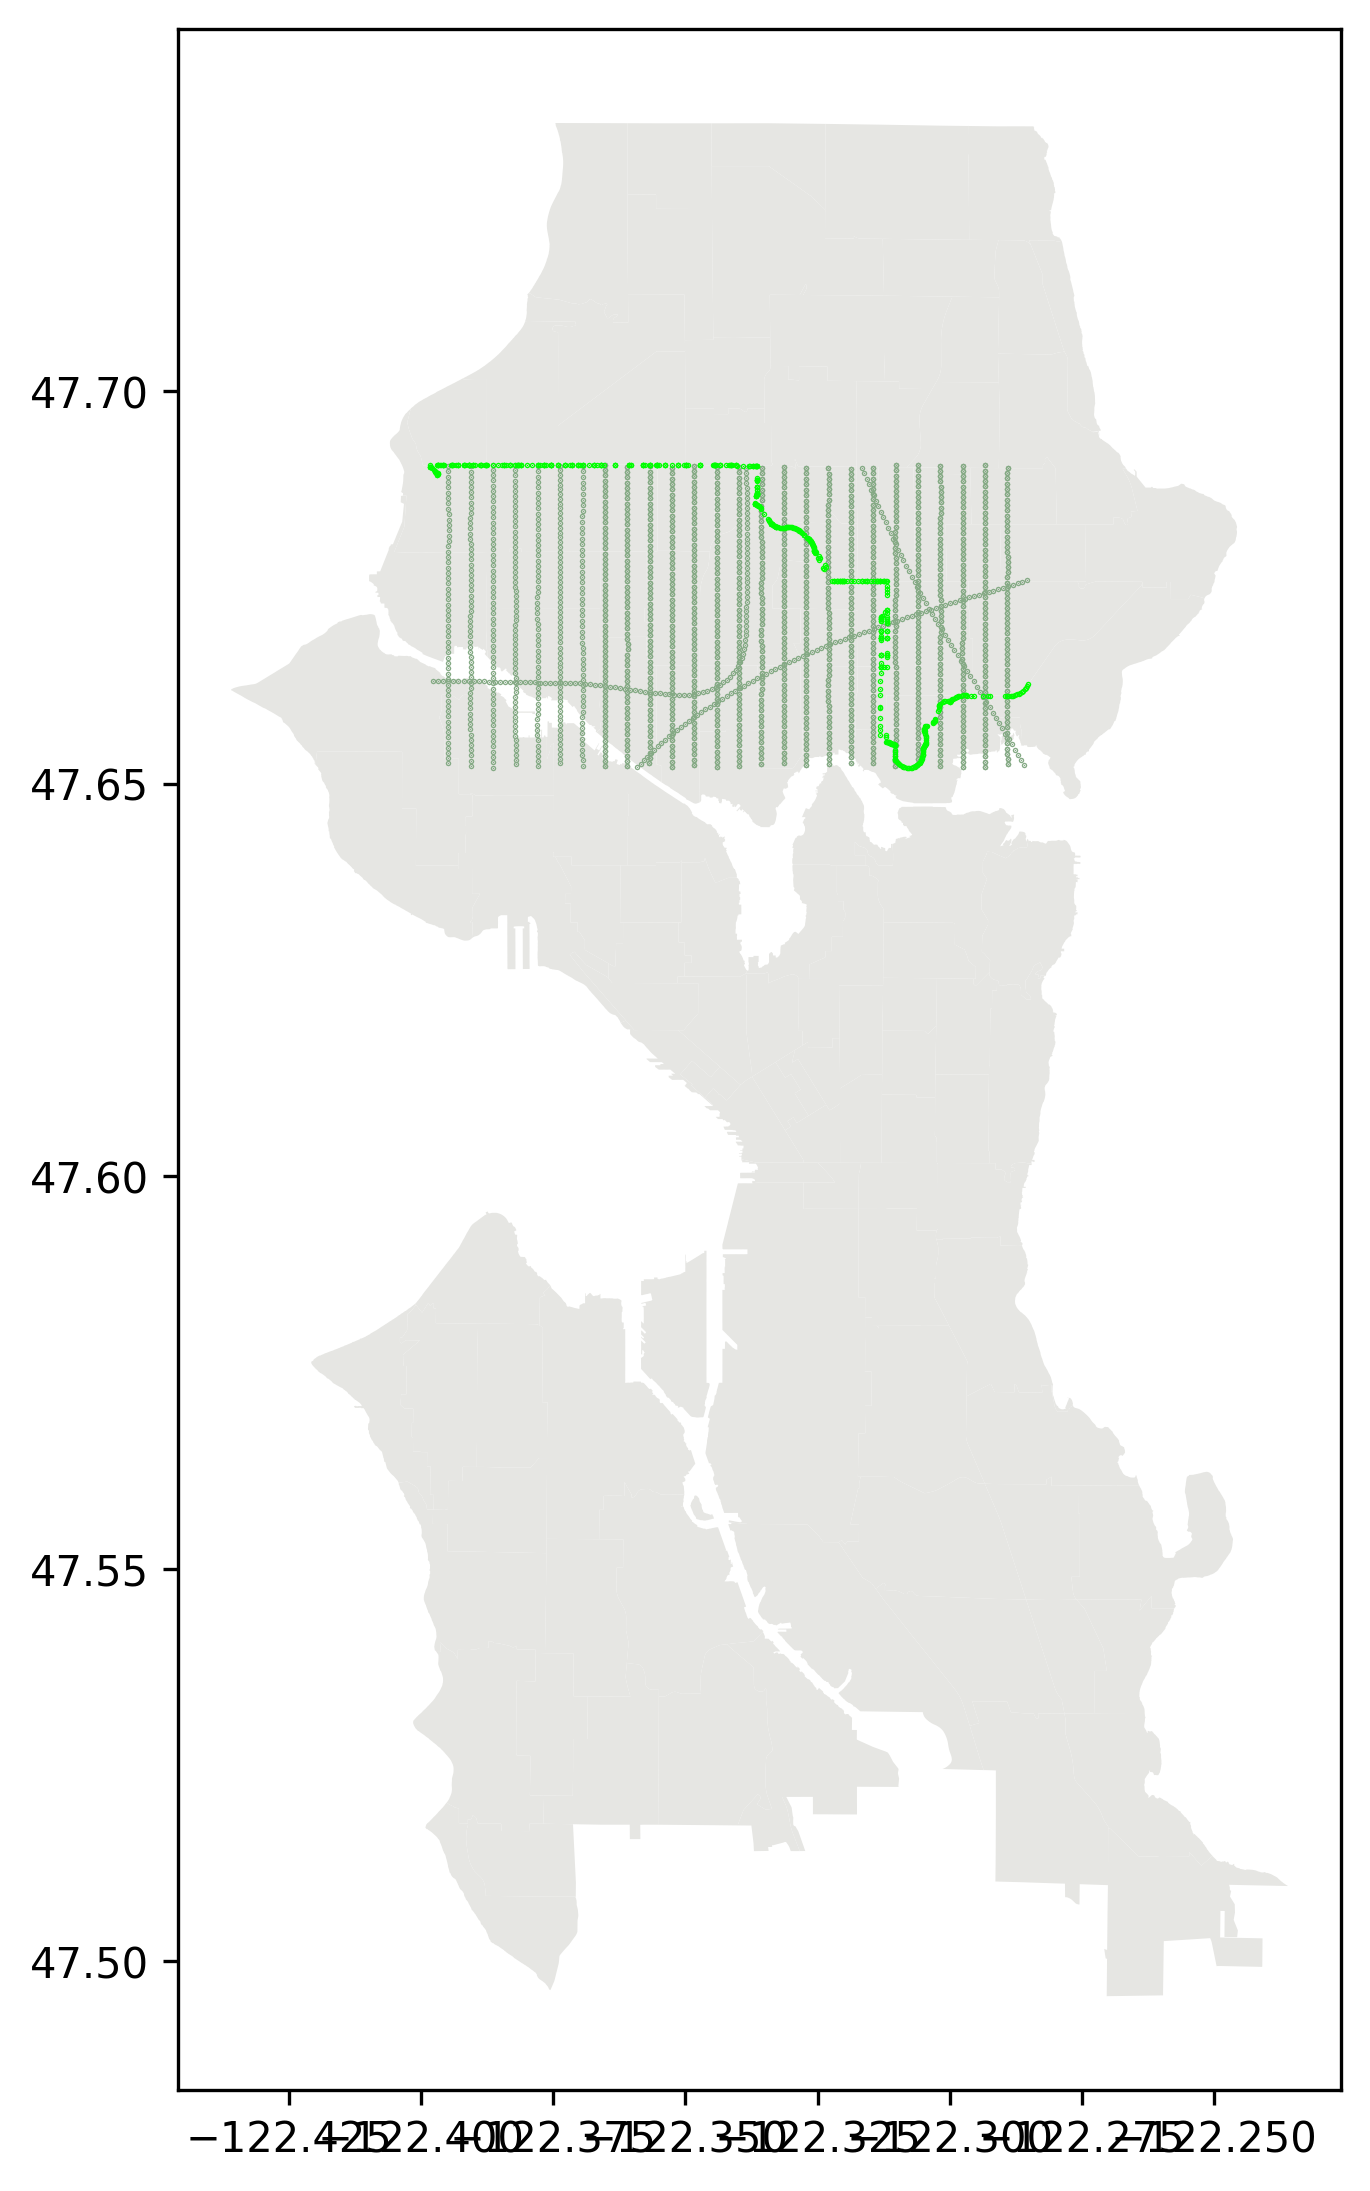

In [256]:
dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])

route_bounds = hm.get_bounding_box(shapely.LineString(geometry))
filtered_elevations = elevations[(elevations['geometry']).apply(lambda x: shapely.contains(route_bounds, x)) == True]

seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
geometry.plot(color="lime", ax=ax, markersize=.1, zorder=15)
filtered_elevations.plot(color="#85AA85", ax=ax, zorder=.5, markersize=.1)


In [210]:
filtered_elevations

,OBJECTID,SERIAL_ID,area_name,DATA_SOURC,DESCRIP,TILESUFFIX,VINTAGE,Shape_Leng,Shape_Area,geometry


In [9]:
route_data_dir = "./Data/Routes/Individual_Routes/"
routefiles_raw = pd.Series(os.listdir(route_data_dir))
routefiles = routefiles_raw[routefiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
routefiles = routefiles.apply(lambda x: "{}{}".format(route_data_dir, x))

In [297]:
contours_data_dir = "./Data/Contours/"
contourfiles_raw = pd.Series(os.listdir(contours_data_dir))
contourfiles = contourfiles_raw[contours_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
contourfiles = contourfiles.apply(lambda x: "{}{}".format(contours_data_dir, x))

In [306]:
contour = gpd.read_file(contourfiles[0]).to_crs(epsg = 4326)

<Axes: >

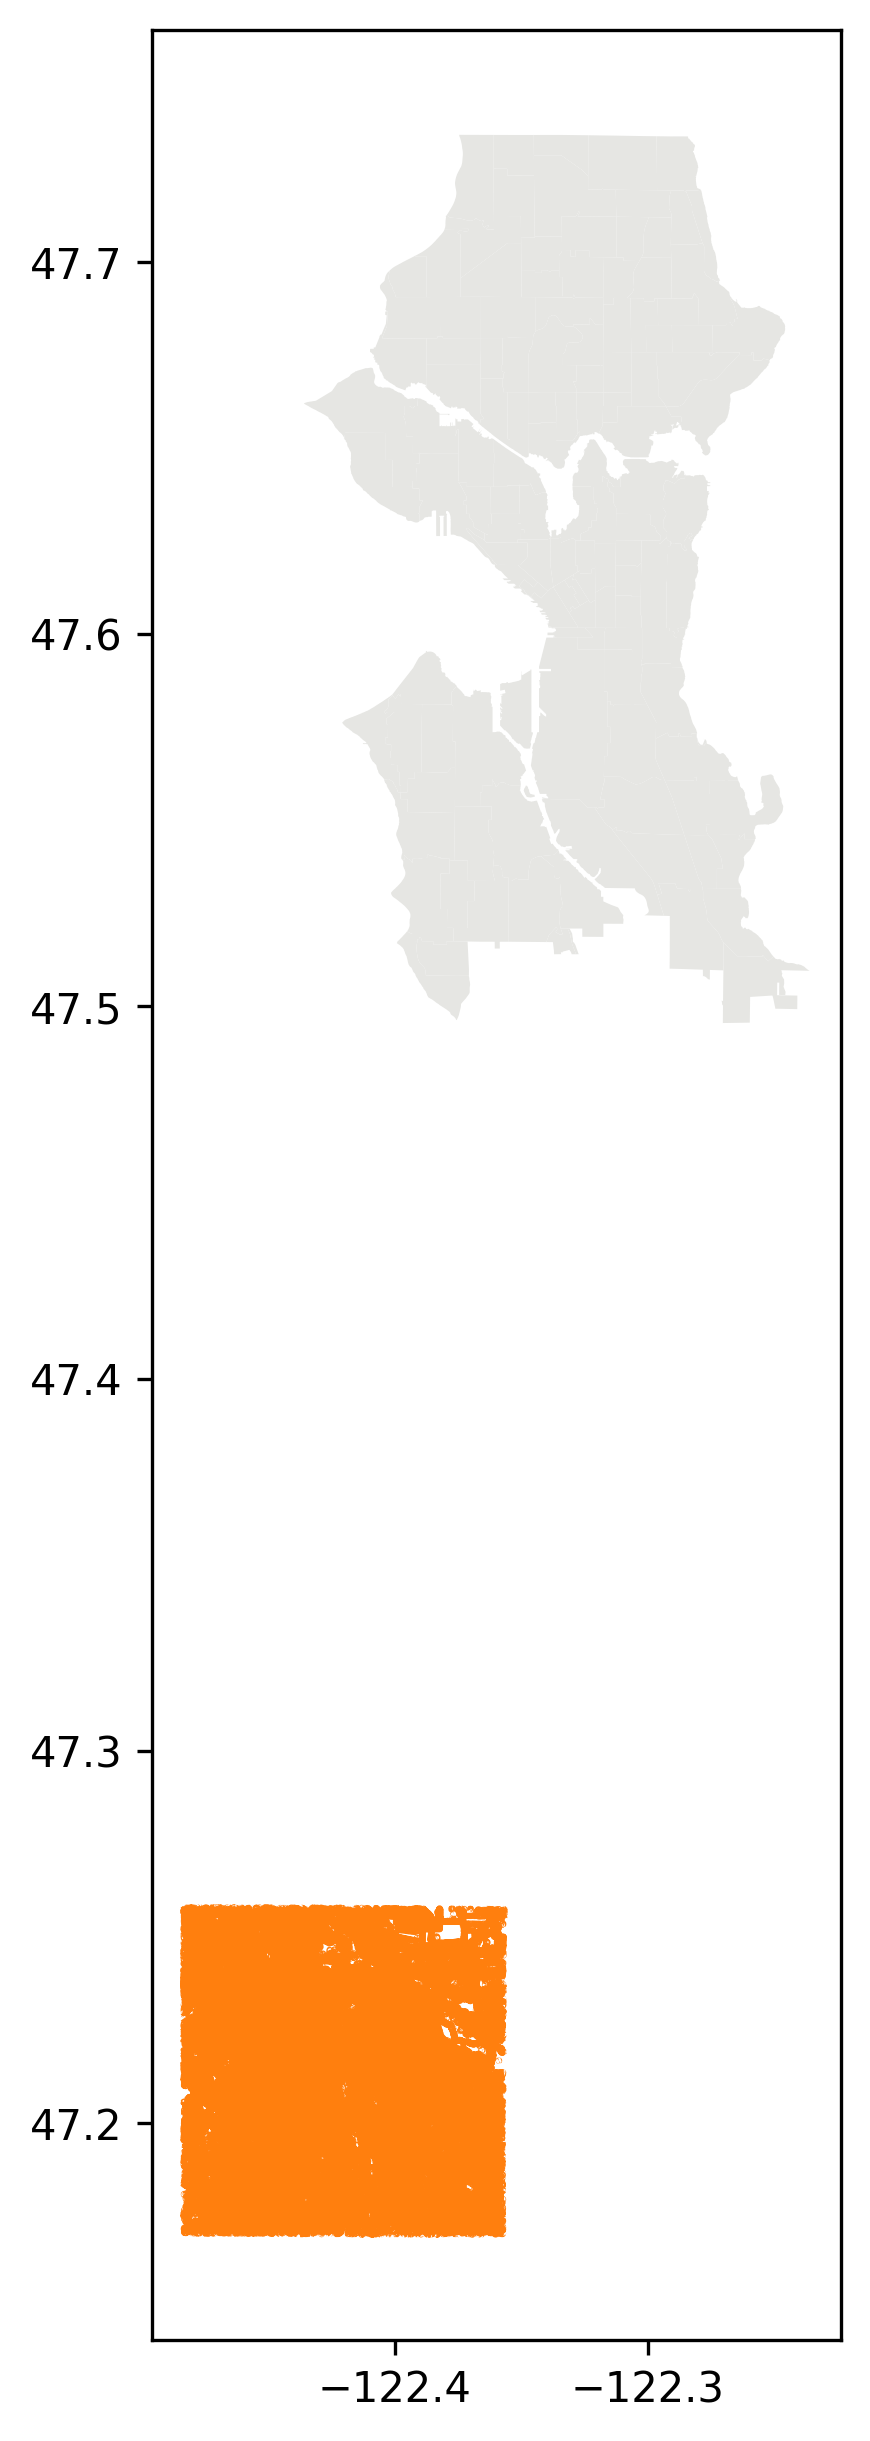

In [308]:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
contour.plot(color="tab:orange", ax=ax, markersize=.1)